In [11]:
import torch
from torch import nn
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [29]:
def plot_decision_boundary2(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y."""
    # se sto lavorafo in CPU e GPU cambiare device qui
    # CPU -> works better with NumPy + Matplotlib)
    # model.to("cpu")
    # X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())



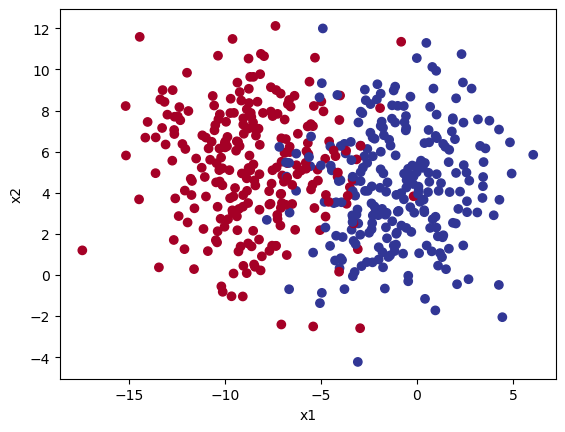

In [30]:
n_samples = 500

X , y = make_blobs( n_samples,
                    centers=2,
                    cluster_std=2.9,
                    random_state=7)

plt.xlabel("x1")
plt.ylabel("x2")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);
# tensors and splits
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

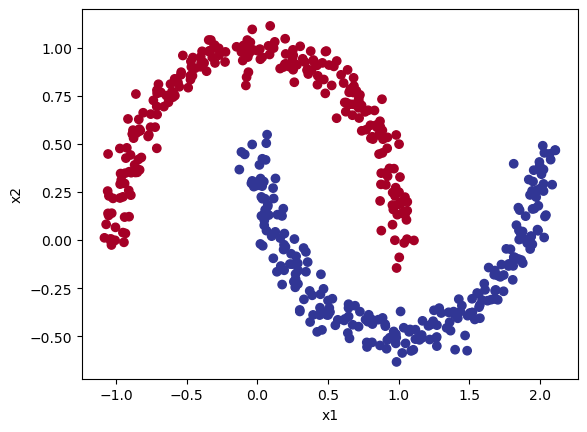

In [36]:
n_samples = 500

X , y = make_moons( n_samples,
                    random_state=7,
                    noise= 0.06)

plt.xlabel("x1")
plt.ylabel("x2")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);
# tensors and splits
X = torch.from_numpy(X).type(torch.float)

In [37]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=7)

X_train[:5], y_train[:5]

(tensor([[ 0.2027,  0.9149],
         [ 0.9789,  0.2722],
         [-0.0640,  0.8719],
         [ 0.9577,  0.2472],
         [ 1.1634, -0.4929]]),
 array([0, 0, 0, 0, 1]))

In [38]:
### build model

class Modello1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer_3(self.relu(
                    self.layer_2(self.relu(
                        self.layer_1(x)))))
        
### deploy model instance

torch.manual_seed(7)
modello_1 = Modello1()
modello_1

Modello1(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [45]:
## criterion, optimizer

criterion_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(modello_1.parameters(),
                            lr=0.03) ## hyperparam

In [47]:
## training LOOP

torch.manual_seed(7)
## torch.cuda.manual_seed(7)

## sedevo andare su GPU, metto qui X_train ecc su GPU
# X_train.to(device)

epochs = 1000

pred_m = np.zeros([X_train.size()[0], epochs],dtype=bool) ## matrice_predizioni

for e in range(epochs):
    modello_1.train()
    
    ## 1 - forward pass
    
    y_logits = modello_1(X_train).squeeze() 
    ## tolgo una dimensione, passo i dati e ottengo dei logits raw, 
    ## che sono dati che passati alla sigmoide mi ritornano una distribuzione di prob
    y_pred = torch.round(torch.sigmoid(y_logits)) ## arrotondo al label più vicino (0,1)
    
    
    ## 2 - applico criterion
    criterion = criterion_fn(y_logits, y_train) 
        ## lo vuole con il logit, dice che è più stabile,
        ## sennò potrei usare tranquillamente nn.BCELoss 
            # che prende l'output dopo il sigmoide (controllare)
    acc = accuracy_fn( y_true=y_train,
                       y_pred=y_pred)
    
    ## 3 - azzero i gradienti (non serve la prima epoch)
            ## però sennò si accumulano dopo il tracking
    optimizer.zero_grad()
    
    ## 4 - BackPropagation
    criterion.backward()
    
    ## 5 - step optimizer
    optimizer.step()
    

    ## Per i Forgetting events prendo una matrice, così in futuro
    ## puo far comodo per ignorare o ricordarsi di pattern ecc
    ## creazione matrice di predizioni corrette o errate
    ## USO XNOR -> xnor(0 0) = 1 | xnor(1 1) = 1 | else 0
    pred_m[:,e] = np.logical_not(
                    np.logical_xor(
                        y_train.numpy(),
                        y_pred.detach().numpy()))
    

    ## Test
    modello_1.eval()
    with torch.inference_mode(): ## non tracko grad
        test_logits = modello_1(X_test).squeeze()
        test_pred= torch.round(torch.sigmoid(test_logits))
        test_criterion = criterion_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                                    y_pred= test_pred)
        
        
    ## stampa aggiornamento ogni qualche epoca
    if e % (epochs / 10) == 0:
        print(f"Epoch: {e}| criterion: {criterion:.4f}, Acc: {acc:.2f}% | Test Crit: {test_criterion:.4f}  Test_Acc: {test_acc:.2f}%")



TypeError: 'int' object is not callable

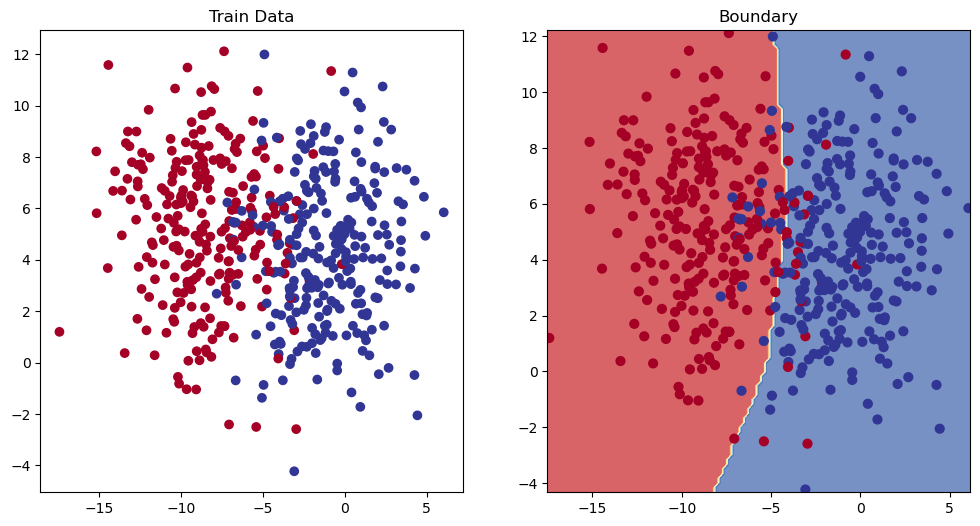

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train Data")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);
plt.subplot(1,2,2)
plt.title("Boundary")
plot_decision_boundary2(modello_1, X, y)

In [45]:
np.array((y_train.numpy()), dtype=bool).size

450

In [46]:
total_true = np.zeros(epochs)
for e in range(epochs) :
    unique, counts = np.unique(pred_m[:,e], return_counts=True)
    total_true[e] = dict(zip(unique,counts))[True]

In [47]:
forgetting_events = np.sum(np.diff(pred_m.astype(int)) == -1, axis = 1)
max(forgetting_events)

2

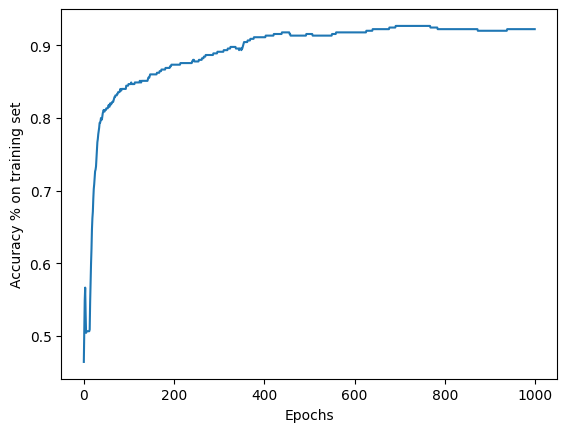

In [48]:
plt.ylabel("Accuracy % on training set")
plt.xlabel("Epochs")
plt.plot(range(0,epochs),total_true/(X_train.size()[0]))

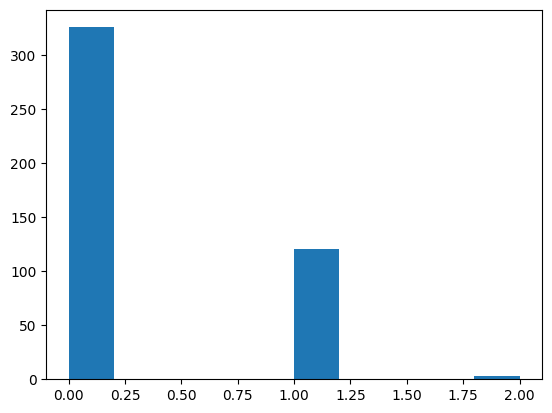

In [49]:
plt.hist(forgetting_events, bins=10);

In [51]:
indices = np.where(forgetting_events > 1)
indices

(array([ 29, 148, 276]),)

TypeError: _unique2(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

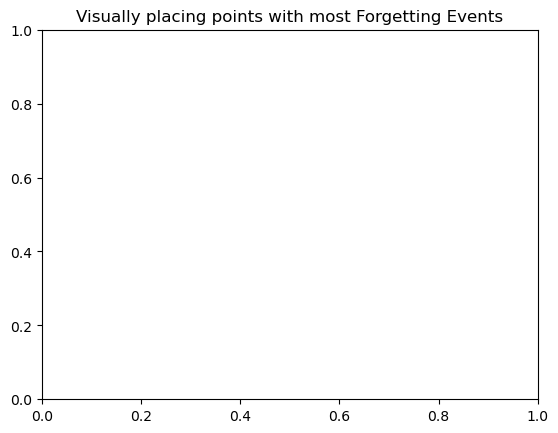

In [28]:
plt.title("Visually placing points with most Forgetting Events")
plot_decision_boundary2(modello_1, X, y)
plt.xlabel("x1")
plt.ylabel("x2")
plt.scatter(X[indices, 0], X[indices, 1], color="yellow", marker="1");